# 0. 경로 지정하기, 데이터셋 불러오기, 라이브러리 설치하기

본 베이스라인 코드는 **모든 참가자들이 최소한의 제출을 할 수 있도록** 간단하게 만든 코드입니다. 이 코드를 토대로 자유롭게 수정하거나 다른 아이디어를 추가하여도 괜찮습니다. 당연히 베이스라인 코드를 참고하지 않고 처음부터 코드를 작성하여도 무방합니다.

In [ ]:
# 구글 드라이브를 코랩과 연결하는 코드입니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 현재 경로를 지정하는 코드입니다.
%cd '/content/drive/MyDrive/iNThon'

/content/drive/MyDrive/iNThon


In [ ]:
# 베이스라인 코드를 실행하기 위하여 필요한 라이브러리를 설치하는 코드입니다.
!pip install fastapi kaleido python-multipart uvicorn
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib jsonlines rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.
  Installing build depe

jsonl 형식의 데이터셋을 불러오는 코드입니다.

    {
      "id": 1,
      "type": "Type 2",
      "size": 6,
      "set": "또#이상#준다#핀잔#사#티셔츠",
      "sentence": "또 이상한 티셔츠를 사서 핀잔을 준다."
    },
    {
      "id": 2,
      "type": "Type 1",
      "size": 6,
      "set": "탄다#해변#썰물 때#말#사람#세",
      "sentence": "썰물 때에 세명의 사람들이 해변에서 말을 탄다."
    },
    ...

데이터의 형태는 위와 같습니다. 가장 간단하게 `"set"`을 입력으로, `"sentence"`를 출력으로 사용할 것입니다. 이후 훈련 집합을 `train.jsonl`에 저장하였습니다.
또한 위에서 `"sentence"`가 빠진 형태인 평가 집합을 `eval.jsonl`에 저장하였습니다.

다른 변수들도 학습에 도움이 될 것이라고 판단하신다면 자유롭게 수정하셔도 좋습니다. 여러분의 아이디어를 보여 주세요!

In [ ]:
# 데이터셋을 위의 설명대로 변환하는 코드입니다.
import jsonlines
import json

input_file_path = 'train.json'
train_file_path = 'train.jsonl'

with open(input_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

with jsonlines.open(train_file_path, mode='w') as writer:
    for item in data['dataset']:
        writer.write({"input": item["set"], "output": item["sentence"]})

input_file_path = 'test.json'
eval_file_path = 'eval.jsonl'

with open(input_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

with jsonlines.open(eval_file_path, mode='w') as writer:
    for item in data['dataset']:
        writer.write({"input": item["set"]})

(train_file_path, eval_file_path)

('train.jsonl', 'eval.jsonl')

In [ ]:
# 데이터셋을 불러오는 코드입니다.
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='eval.jsonl', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# 1. 가속기

PyTorch의 Fully Sharded Data Parallel (FSDP) 기능을 사용하여 대규모 딥러닝 모델을 효율적으로 학습하기 위한 설정을 정의합니다. `FullyShardedDataParallelPlugin`을 사용하여 모델과 옵티마이저의 상태를 CPU로 오프로드하고, 모든 프로세스가 아닌 일부 프로세스에만 상태를 저장하도록 구성합니다.

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# 2. 베이스 모델 불러오기

Hugging Face의 Transformers 라이브러리를 사용하여 사전 훈련된 언어 모델을 로드합니다. 베이스라인에는 `
EleutherAI/polyglot-ko-1.3b`라는 언어 모델을 사용하였습니다.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "EleutherAI/polyglot-ko-1.3b"
model = AutoModelForCausalLM.from_pretrained(base_model_id)

config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/748M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

# 3. 토큰화

1. **토크나이저 설정**: Hugging Face의 `AutoTokenizer`를 사용하여 주어진 모델 ID에 맞는 토크나이저를 로드합니다. 여기서 토크나이저는 입력의 왼쪽에 패딩을 추가하고, 시작과 끝 토큰을 추가하도록 설정됩니다. 또한, 패딩 토큰으로 EOS(end-of-sequence) 토큰을 사용합니다.

2. **데이터셋 토큰화**: `generate_and_tokenize_text` 함수를 사용하여 학습(`train_dataset`)과 평가(`eval_dataset`) 데이터셋을 토큰화합니다. 이 함수는 일반적으로 입력 텍스트를 모델에 적합한 형식으로 변환합니다.

3. **데이터 길이 분포 시각화**: `plot_data_lengths` 함수는 토큰화된 학습 및 검증 데이터셋에서 각 입력의 길이(토큰의 수) 분포를 히스토그램으로 시각화합니다. 이는 데이터의 특성을 이해하고 적절한 모델 및 훈련 설정을 결정하는 데 도움이 됩니다.

4. **토큰화 함수의 정의와 재적용**: `generate_and_tokenize_prompt` 함수를 정의한 후, 학습 및 검증 데이터셋에 다시 적용하여 최대 길이로 토큰화하고, 입력 ID를 레이블로 복사합니다. 이렇게 함으로써 언어 모델 학습을 위한 데이터 준비가 완료됩니다.

In [ ]:
# autoreload를 사용하여 코드를 수정하고 저장하면 자동으로 적용되도록 하는 코드입니다.
%load_ext autoreload
%autoreload 2


In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [2]:
base_model_id = 'gogamza/kobart-base-v2'
model = AutoModelForSeq2SeqLM.from_pretrained(base_model_id)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
tokenizer

In [6]:
model.generate('안녕하세요', num_beams=5, num_return_sequences=5, max_length=100, early_stopping=True)

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
# Training code using bart model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

def preprocess_function(examples):
    inputs = ['<pad>'.join(doc.split('#')) for doc in examples["input"]]
    model_inputs = tokenizer(inputs, padding="max_length", max_length=256, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["output"], padding="max_length", max_length=32, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_dataset = train_dataset.map(
    preprocess_function, batched=True, num_proc=4, load_from_cache_file=True
)
tokenized_eval_dataset = eval_dataset.map(
    preprocess_function, batched=True, num_proc=4, load_from_cache_file=True
)

In [ ]:
args = Seq2SeqTrainingArguments(
    "kobart",
    num_train_epochs=1,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=3,
    remove_unused_columns=True,
    logging_strategy="epoch",
    evaluation_strategy = "steps",
    eval_steps = 300,
    save_strategy="steps",
    save_steps=300,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
)

trainer.train()

In [ ]:
# Generate Texts in eval dataset
import torch
import jsonlines
from tqdm.auto import tqdm

model = model.to("cuda")
model.eval()

with jsonlines.open('eval.jsonl', mode='r') as reader:
    data = [item for item in reader]

with jsonlines.open('eval_result.jsonl', mode='w') as writer:
    for item in tqdm(data):
        input = item['input']
        input = '<pad>'.join(input.split('#'))
        input = tokenizer(input, return_tensors='pt', padding=True, truncation=True).to("cuda")
        generated_ids = model.generate(input['input_ids'], num_beams=5, num_return_sequences=5, max_length=32, no_repeat_ngram_size=2)
        generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        item['output'] = generated_texts
        writer.write(item)
        

In [ ]:
# Generate text using trained model
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def generate_text(text, model, tokenizer, max_length=256):
    input_ids = tokenizer(text, return_tensors='pt')['input_ids'].to(model.device)
    outputs = model.generate(input_ids, max_length=max_length, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

generate_text('나는', model, tokenizer)

In [ ]:
# 토크나이저를 설정하는 코드입니다.
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def formatting_func(example):
    text = f"{example['input']}"
    return text

def generate_and_tokenize_text(text):
    return tokenizer(formatting_func(text))

tokenizer_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
# 데이터셋에 있는 각각의 데이터를 토큰화하는 코드입니다.
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_text)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_text)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

31500


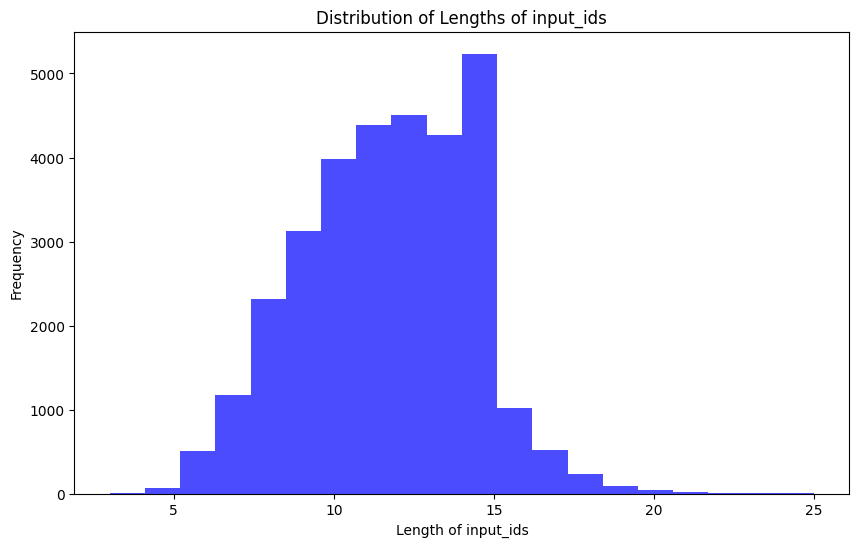

In [ ]:
# 데이터 길이 분포를 시각화하는 코드입니다.
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
# 패딩을 포함한 토크나이저를 설정하고 적용하는 코드입니다.
max_length = 128

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

# 4. 베이스 모델 작동 확인 (선택)

사전 훈련된 언어 모델을 사용하여 주어진 평가 데이터셋(`eval_dataset`)에 대한 예측을 생성하고 저장하는 코드입니다.

1. **데이터 읽기와 쓰기 설정**: `jsonlines` 라이브러리를 사용하여 평가 데이터셋(`eval.jsonl`)을 읽고, 결과를 저장할 파일(`predictions.jsonl`)을 쓰기 모드로 엽니다.

2. **평가 데이터셋 처리**: `tqdm`을 사용하여 진행 상황을 표시하면서 평가 데이터셋을 순회합니다. 각 데이터 포인트에 대해, 평가 입력을 기반으로 질문-답변 형식의 프롬프트를 생성합니다.

3. **모델 입력 준비**: 생성된 프롬프트를 토크나이저를 통해 모델이 처리할 수 있는 형식으로 변환하고, 이를 CUDA를 사용하는 GPU로 이동시킵니다.

4. **모델 실행**: 모델을 평가 모드로 설정하고, `torch.no_grad()`를 사용하여 기울기 계산 없이 모델을 실행합니다. `model.generate` 함수를 사용하여 답변을 생성하고, 이를 디코딩하여 텍스트 형식으로 변환합니다.

5. **결과 저장**: 각 평가 입력과 해당하는 생성된 답변을 `predictions.jsonl `파일에 저장합니다.

In [ ]:
import jsonlines
from tqdm import tqdm
import warnings

with jsonlines.open('eval.jsonl') as reader, jsonlines.open('predictions.jsonl', mode='w') as writer:
    for eval_entry in tqdm(reader, total=len(eval_dataset)):
        eval_input = eval_entry['input']

        eval_prompt = f"{eval_input}"

        model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

        model.eval()

        with torch.no_grad():
            output = model.generate(**model_input, max_new_tokens=32, pad_token_id=tokenizer.eos_token_id)
            answer = tokenizer.decode(output[0], skip_special_tokens=True)

        writer.write({"input": eval_input, "output": answer})

print("Predictions have been written to predictions.jsonl")

# 5. LoRA 설정
모델을 최적화하고 효율적으로 학습하기 위한 단계입니다.

1. **그라디언트 체크포인팅 활성화**: `model.gradient_checkpointing_enable()`를 호출하여 모델의 메모리 사용량을 줄이기 위해 그라디언트 체크포인팅을 활성화합니다. 이는 특히 대규모 모델에서 유용합니다.

2. **PEFT 모델 준비**: **prepare_model_for_kbit_training** 함수를 사용하여 모델을 PEFT(Parameter-Efficient Fine-Tuning)에 적합하게 조정합니다.

Few-Shot **P**arameter-**E**fficient **F**ine-**T**uning is Better and Cheaper than In-Context Learning: https://arxiv.org/abs/2205.05638

3. **훈련 가능한 파라미터 수 계산 및 출력**: `print_trainable_parameters` 함수는 모델의 전체 파라미터 수와 그 중 훈련 가능한 파라미터의 수를 계산하여 출력합니다.

4. **LoRA 설정**: `LoraConfig`를 사용하여 LoRA(Low-Rank Adaptation) 설정을 정의합니다.

LoRA: **Lo**w-**R**ank **A**daptation of Large Language Models: https://arxiv.org/abs/2106.09685

5. **PEFT 모델 가져오기**: `get_peft_model` 함수를 사용하여 LoRA 설정을 적용한 모델을 가져옵니다.

6. **훈련 가능한 파라미터 재계산 및 출력**: 변경된 모델의 훈련 가능한 파라미터 수를 다시 계산하고 출력합니다.

7. **모델을 Accelerator와 통합**: `accelerator.prepare_model`을 사용하여 모델을 Accelerator 라이브러리와 통합합니다. 이는 분산 훈련 및 다른 최적화 기법과의 호환성을 위해 필요합니다.

In [ ]:
# 그라디언트 체크포인팅을 활성화하는 코드입니다.
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
# 훈련 가능한 파라미터의 수를 계산해 주는 함수입니다.
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(30080, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
  

In [ ]:
# LoRA를 이용해 학습하고자 하는 계층을 결정하여 PEFT 모델을 준비하는 코드입니다.
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "embed_out",
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

model = accelerator.prepare_model(model)

trainable params: 1028096 || all params: 1332838400 || trainable%: 0.07713583282114321


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(30080, 2048)
        (emb_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-23): 24 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
            (post_attention_dropout): Dropout(p=0.0, inplace=False)
            (post_mlp_dropout): Dropout(p=0.0, inplace=False)
            (attention): GPTNeoXAttention(
              (rotary_emb): GPTNeoXRotaryEmbedding()
              (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
              (dense): Linear(in_features=2048, out_features=2048, bias=True)
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (mlp): GPTNeoXMLP(
              (dense_h_to_4h): Linear(in

# 6. 모델 훈련

1. **토크나이저 설정**: 패딩 토큰으로 EOS 토큰을 사용하도록 토크나이저를 설정합니다.

2. **훈련 매개변수 설정**: 에포크 수, 배치 크기, 그래디언트 축적 단계 등 훈련에 필요한 매개변수를 설정합니다.

3. **트레이너 설정**: Hugging Face의 Trainer 클래스를 사용하여 모델, 데이터셋, 훈련 매개변수 및 기타 옵션을 설정합니다. 여기에는 학습률, 최적화기, 스케줄러 타입, 로깅 및 저장 전략 등이 포함됩니다.

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50", src_lang="ko_KR", tgt_lang="ko_KR")

In [ ]:
# 로컬이나 구글 드라이브에 저장할 체크포인트의 경로를 설정하는 코드입니다.
import transformers
from datetime import datetime

project = "baseline-finetune"
base_model_name = "EleutherAI/polyglot-ko-1.3b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# 모델을 학습하는 코드입니다. 훈련 매개변수는 자유롭게 변경하셔도 됩니다.

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=64,
        max_steps=100,
        learning_rate=1e-4,
        optim="adamw_torch",
        gradient_accumulation_steps=16,
        weight_decay=0.1,
        lr_scheduler_type='linear',
        warmup_steps=0,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=10,
        save_total_limit=3,
        evaluation_strategy="epoch",
        load_best_model_at_end=False,
        metric_for_best_model="loss",
        greater_is_better=False
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer,
        mlm=False
    ),
)

model.config.use_cache = False
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,No log,5.914606
1,No log,5.690587
2,No log,5.567279
3,No log,5.553551


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=100, training_loss=5.98102783203125, metrics={'train_runtime': 1562.5806, 'train_samples_per_second': 65.533, 'train_steps_per_second': 0.064, 'total_flos': 2.498177273954304e+16, 'train_loss': 5.98102783203125, 'epoch': 3.41})

# 7. 모델 평가

1. **모델 로드**: `AutoModelForCausalLM`과 `AutoTokenizer`를 사용하여 `EleutherAI/polyglot-ko-1.3b` 모델과 해당 토크나이저를 로드합니다. 모델은 양자화 설정과 함께 로드됩니다.

2. **PeftModel 불러오기**: 미세 조정된 모델(PeftModel)을 로드합니다.

3. **모델 실행**: 모델을 평가 모드로 설정하고, 각 입력에 대해 프롬프트를 생성합니다.

4. **예측 생성**: 모델을 사용하여 각 프롬프트에 대한 답변을 생성합니다. 각 입력에 대한 예측을 생성한 후 `predictions_baseline_trained.jsonl` 파일에 저장합니다.

5. **생성된 텍스트 평가**: 자연어처리 분야의 평가 지표인 ROUGE와 BERTscore를 사용하여 생성된 문장과 데이터셋의 문장을 비교하고 생성된 문장을 평가합니다. 베이스라인 코드에 평가를 명시적으로 진행하는 예시를 포함하고자 훈련 집합의 일부를 통해 점수를 계산했습니다. **실제 평가는 평가 집합으로 진행할 예정입니다.**

In [ ]:
# 베이스 모델을 불러오는 코드입니다.
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
base_model_id = "EleutherAI/polyglot-ko-1.3b"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# 미세 조정한 모델의 정보가 들어있는 체크포인트를 불러오는 코드입니다.
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "EleutherAI/polyglot-ko-1.3b-baseline-finetune/checkpoint-100")

In [ ]:
# 체크포인트의 가중치로부터 문장을 생성하는 코드입니다.
import jsonlines
from tqdm import tqdm

ft_model.eval()

with jsonlines.open('train.jsonl') as reader, jsonlines.open('predictions_baseline_trained.jsonl', mode='w') as writer:
    for i, eval_entry in enumerate(tqdm(reader, total=100)):
        if i >= 100:
            break # 베이스라인 실행의 간편함을 위하여 첫 100개의 데이터에 대하여 평가를 진행했습니다.

        eval_input = eval_entry['input']

        eval_prompt = f"{eval_input}"

        model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
        if "token_type_ids" in model_input:
            del model_input["token_type_ids"]

        model.eval()

        with torch.no_grad():
            output = ft_model.generate(**model_input, max_new_tokens=32, pad_token_id=2)
            answer = tokenizer.decode(output[0], skip_special_tokens=True)

        writer.write({"input": eval_input, "output": answer})

print()
print("Predictions have been written to predictions_baseline_trained.jsonl")

100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


Predictions have been written to predictions_baseline_trained.jsonl


    predictions.append(''.join(pred["output"].split(pred["input"])[1:]))

`predictions_baseline_trained.jsonl` 파일에 있는 각 행의 "output"이라는 키의 구조는 다음과 같습니다.

`"output" = "input"에 해당하는 주어진 텍스트 + 새롭게 만들어낸 텍스트`

하지만 위 코드에서 볼 수 있는 것과 같이 **"input"에 해당하는 주어진 텍스트의 다음 텍스트**, 즉 새롭게 만들어낸 텍스트부터 채점에 포함할 예정입니다.

In [ ]:
# 평가를 위한 bertscore 라이브러리를 설치하는 코드입니다. rouge 라이브러리는 0번에서 설치를 진행했습니다.
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
# 생성된 텍스트를 평가하는 코드입니다.
from rouge import Rouge
from bert_score import score

predictions_file = 'predictions_baseline_trained.jsonl'
eval_file = 'train.jsonl'

predictions = []
references = []
with jsonlines.open(predictions_file) as pred_reader, jsonlines.open(eval_file) as eval_reader:
    for i, (pred, eval) in enumerate(zip(pred_reader, eval_reader)):
        if i >= 100:
            break
        predictions.append(''.join(pred["output"].split(pred["input"])[1:]))
        references.append(eval["output"])

rouge = Rouge()
rouge_scores = rouge.get_scores(predictions, references, avg=True)

P, R, F1 = score(predictions, references, lang="ko", model_type="bert-base-multilingual-cased")
bertscore = F1.mean()

print("ROUGE-1:", round(rouge_scores['rouge-1']['f'], 4))
print("ROUGE-2:", round(rouge_scores['rouge-2']['f'], 4))
print("ROUGE-L:", round(rouge_scores['rouge-l']['f'], 4))
print("BERTScore:", round(bertscore.item(), 4))

print()
print("Final Score:", round(0.1 * rouge_scores['rouge-1']['f'] + 0.1 * rouge_scores['rouge-2']['f'] +
                            0.2 * rouge_scores['rouge-l']['f'] + 0.6 * bertscore.item(), 4))

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

ROUGE-1: 0.0107
ROUGE-2: 0.0031
ROUGE-L: 0.0107
BERTScore: 0.5748

Final Score: 0.4048


# 8. 결과 제출
세 개의 파일(`test.json`, `eval.jsonl`, `predictions_baseline_trained.jsonl`)을 사용하여 특정 데이터를 추출하고 이를 판다스 데이터프레임으로 변환합니다.

1. **JSON 파일 로드**: `test.json` 파일을 열어 JSON 데이터를 파싱합니다.

2. **eval.jsonl 파일 처리**: `eval.jsonl` 파일을 열어 각 항목의 `"input"` 키에 해당하는 값을 키로 하여 딕셔너리(`eval_data`)를 구성합니다.

3. **predictions_baseline_trained.jsonl 파일 처리**: `predictions_baseline_trained.jsonl` 파일을 열어 각 항목에서 모델이 새롭게 만들어낸 텍스트를 추출하여, 해당 `"input"` 키에 대응하는 값으로 딕셔너리(`predictions_data`)를 구성합니다.

4. **데이터프레임 생성**: 각 `set`의 `id`와 `eval.jsonl` 파일의 `"input"`이 일치하는 경우, 이에 해당하는 `predictions_baseline_trained.jsonl` 파일의 텍스트를 찾아 데이터프레임에 추가합니다. 결과적으로, 각 행은 `id`와 관련된 텍스트(`sentence`)로 구성됩니다.

최종적으로 이 코드는 세 파일 간의 관계를 매핑하여, 각 `id`에 대응하는 예측된 텍스트를 포함하는 데이터프레임을 생성합니다.

Kaggle에 최종적으로 제출해야 하는 양식은 다음과 같습니다.

|    id    |  sentence  |
|----------|------------|
| 30001    | 답안 1     |
| 30002    | ​​​​​​​​​​​​​​​​​​​​​​답안 2     |
| 30003    | 답안 3     |
| 30004    | 답안 4     |
| 30005    | 답안 5     |
| ...      | ...        |
| 31496    | 답안 1496  |
| 31497    | 답안 1497  |
| 31498    | 답안 1498  |
| 31499    | 답안 1499  |
| 31500    | 답안 1500  |


형식에 주의하여 모델의 성능보다 떨어지는 점수를 얻는 일이 없도록 합시다!

In [ ]:
# json, jsonl 파일을 처리하여 제출에 필요한 데이터들을 골라내는 코드입니다.
import json
import pandas as pd

json_file_path = 'train.json' # 'test.json'
eval_file_path = 'train.jsonl' # 'eval.jsonl'
predictions_file_path = 'predictions_baseline_trained.jsonl'

with open(json_file_path, 'r', encoding='utf-8') as file:
    json_data = json.load(file)

eval_data = {}
with jsonlines.open(eval_file_path) as reader:
    for entry in reader:
        eval_data[entry['input']] = entry

predictions_data = {}
with jsonlines.open(predictions_file_path) as reader:
    for entry in reader:
        text_after_keyword = ''.join(entry['output'].split(entry['input'])[1:])
        predictions_data[entry['input']] = text_after_keyword

In [ ]:
# 제출 파일의 형식에 맞는 데이터프레임을 생성하는 코드입니다.
df_data = []
for i, data in enumerate(json_data['dataset']):
    if i >= 100:
        break # 제출을 위해 데이터프레임을 생성할 때는 삭제해야 합니다.

    if data['set'] in eval_data:
        id = data['id']
        sentence = predictions_data.get(eval_data[data['set']]['input'], "")
        df_data.append([id, sentence])

df = pd.DataFrame(df_data, columns=['id', 'sentence'])
df

,id,sentence
0,1,################################
1,2,부#세부여행#세부자유여행#세부한달살기#세부한달살기#세부여행#세부여행
2,3,소문#피부#피부#피부#피부#피부#피부#피부#피부#피부#피부#피부#피부#피부#피부#피부#
3,4,#취미#일상#소통#서이추#서이추환영#서로이웃#서로이웃환영#서로이웃추가#서로이웃추가환영
4,5,#립스틱#립스틱#립스틱#립스틱#립스틱#립스틱#립스틱#립스틱#립스틱#립스틱#립
...,...,...
95,96,한 잠을 잘 수 있는 방법은?​​​​​​​​​​​
96,97,#차#속#회색 곰 인형#차#속#회색 곰 인형#차#속#회색 곰 인형#차#속#
97,98,#서#받#아#서########################
98,99,#사랑해#말하지#못했어#미안해#너무#귀여워#말하지#못했어#미안해#


In [ ]:
# 제출 파일을 로컬이나 구글 드라이브에 저장하는 코드입니다.
df.to_csv('submit.csv', index=False, encoding='utf-8')